In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
import os, random, matplotlib, pickle, yaml
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

SMALL_SIZE, MEDIUM_SIZE = 9, 12

<h1><font color="blue">Import Data</font></h1>

In [5]:
result_path = "results/round3_antennae"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])
    
config_path = "."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
tot_bp, tot_bp_scaled, tot_bp_rotated, tot_body_orientation, tot_angles, tot_rotations, tot_power, tot_embed = [], [], [], [], [], [], [], []
for file in tqdm(INFO_values):
    tot_bp.append( np.load(f"{file['directory']}/bodypoints.npy") )
    tot_bp_scaled.append( np.load(f"{file['directory']}/scaled_bodypoints.npy") )
    tot_bp_rotated.append( np.load(f"{file['directory']}/rotated_bodypoints.npy") )
    tot_body_orientation.append( np.load(f"{file['directory']}/body_orientation_angles.npy") )
    tot_angles.append( np.load(f"{file['directory']}/angles.npy") )
    tot_power.append( np.load(f"{file['directory']}/power.npy") )
    tot_embed.append( np.load(f"{file['directory']}/embeddings.npy") )

tot_bp = np.concatenate(tot_bp)
tot_bp_scaled = np.concatenate(tot_bp_scaled)
tot_bp_rotated = np.concatenate(tot_bp_rotated)
tot_body_orientation = np.concatenate(tot_body_orientation)
tot_angles = np.concatenate(tot_angles)
tot_power = np.concatenate(tot_power, axis=2)
tot_embed = np.concatenate(tot_embed)

In [5]:
print(f"tot_bp shape: {tot_bp.shape}")
print(f"tot_bp_unrot shape: {tot_bp_scaled.shape}")
print(f"tot_bp_rotated shape: {tot_bp_rotated.shape}")
print(f"tot_angles shape: {tot_angles.shape}")
print(f"tot_power shape: {tot_power.shape}")
print(f"tot_embed shape: {tot_embed.shape}")

tot_bp shape: (1883492, 30, 3)
tot_bp_unrot shape: (1883492, 30, 3)
tot_bp_rotated shape: (1883492, 30, 3)
tot_angles shape: (1883492, 4, 2)
tot_power shape: (4, 21, 1883492)
tot_embed shape: (1883492, 3)


In [6]:
(good_ang_idx, good_fr_idx) = np.where(tot_power[:,-1,:] == 1)
unique_good_fr = np.unique(good_fr_idx)

In [7]:
unique_good_fr.shape

(1786761,)

<h1><font color="blue">Visualize Data</font></h1>

In [8]:
# %matplotlib qt
%matplotlib inline

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

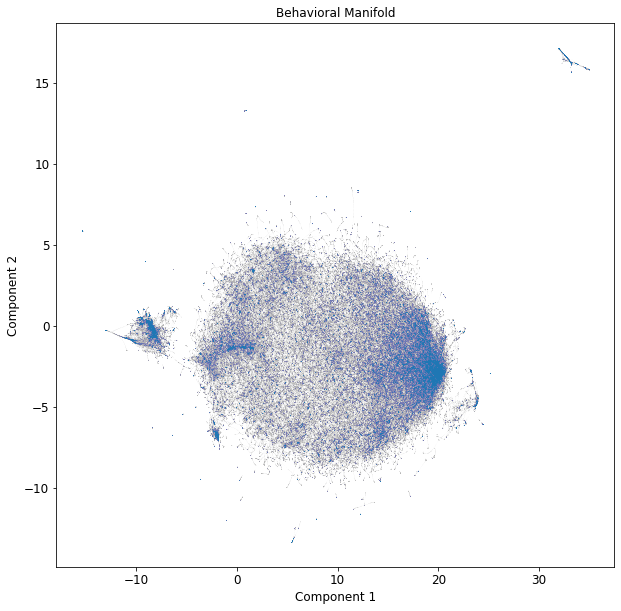

In [9]:
fig_base, ax_base = plt.subplots(figsize=(10,10))
ax_base.scatter(tot_embed[:,0], tot_embed[:,1], alpha=0.002, s=1)  
ax_base.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold")
plt.show()

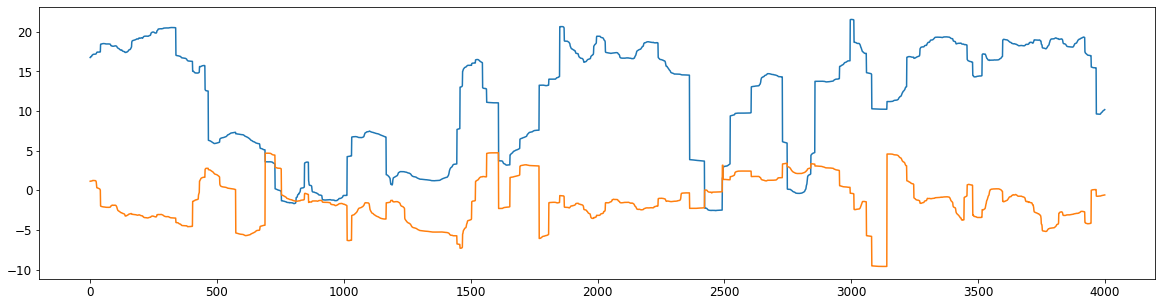

In [10]:
start_fr, stop_fr = 1000,5000
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(tot_embed[start_fr:stop_fr,0])
ax.plot(tot_embed[start_fr:stop_fr,1])
plt.show()

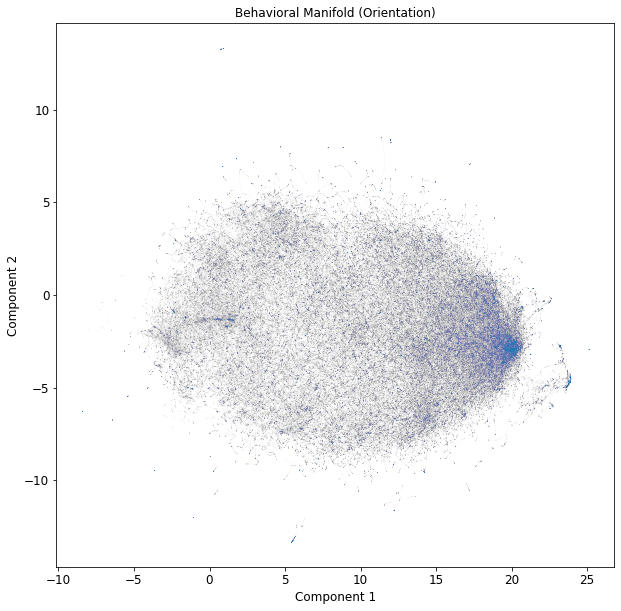

In [11]:
idx = tot_embed[:,-1] == 1
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tot_embed[idx,0], tot_embed[idx,1], alpha=0.005, s=1)  
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (Orientation)")
plt.show()

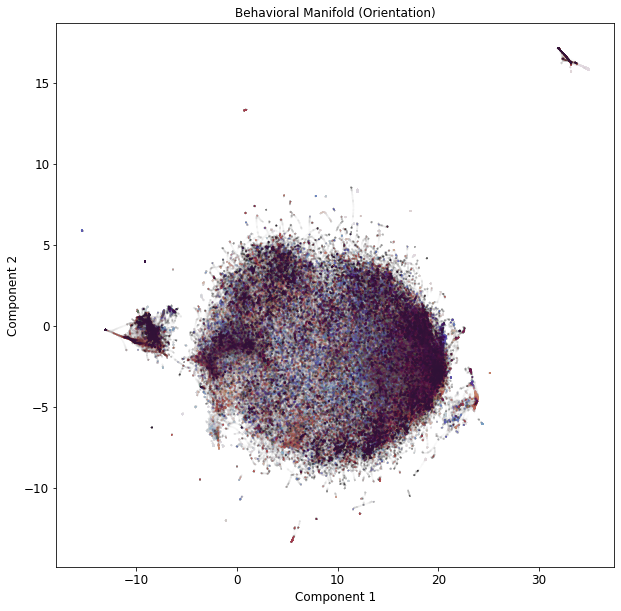

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tot_embed[:,0], tot_embed[:,1], c=tot_body_orientation, alpha=0.005, s=3, cmap="twilight")  
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (Orientation)")
plt.show()

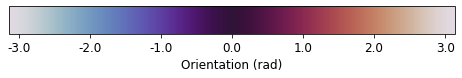

In [40]:
fig, ax = plt.subplots(figsize=(8,1))
fig.subplots_adjust(bottom=0.5)
norm1 = matplotlib.colors.Normalize(vmin=np.min(tot_body_orientation), vmax=np.max(tot_body_orientation))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("twilight"), norm=norm1, orientation='horizontal')
cb1.set_label('Orientation (rad)')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

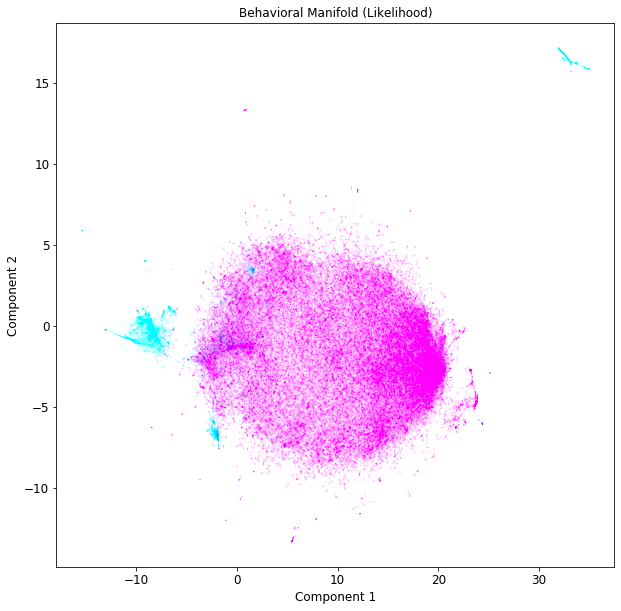

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tot_embed[:,0], tot_embed[:,1], c=tot_embed[:,2], alpha=0.002, s=1, cmap="cool")  
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (Likelihood)")
plt.show()

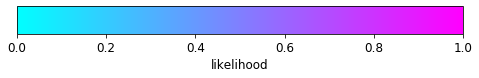

In [42]:
fig, ax = plt.subplots(figsize=(8,1))
fig.subplots_adjust(bottom=0.5)
norm1 = matplotlib.colors.Normalize(vmin=np.min(tot_embed[:,2]), vmax=np.max(tot_embed[:,2]))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap("cool"), norm=norm1, orientation='horizontal')
cb1.set_label('likelihood')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

In [11]:
num_fr, _ = tot_embed.shape
samp_idx = random.sample(range(num_fr), int(num_fr*3/5))
len(samp_idx)

1130095

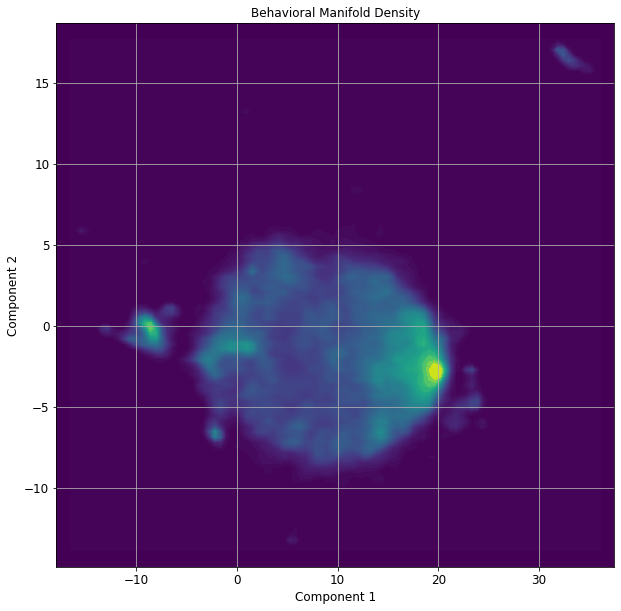

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(x=tot_embed[samp_idx,0], y=tot_embed[samp_idx,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax)
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold Density", facecolor='#440054', xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim())
ax.grid(which="major")
plt.show()

<hr><hr>

<h1><font color="blue">Behavior Manifold + Frequency</font></h1>

In [13]:
# %matplotlib qt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

freq = np.array([ 1.        ,  1.18461108,  1.40330341,  1.66236876,  1.96926045,
        2.33280775,  2.76346991,  3.27363707,  3.87798674,  4.59390605,
        5.441992  ,  6.44664402,  7.63676592,  9.04659752, 10.71669965,
       12.69512113, 15.03878113, 17.81510674, 21.10397281, 25.        ])

In [14]:
config['angle_labels'] = ['(R) Antennae',
 '(R) Antennae 2',
 '(L) Antennae',
 '(L) Antennae 2']

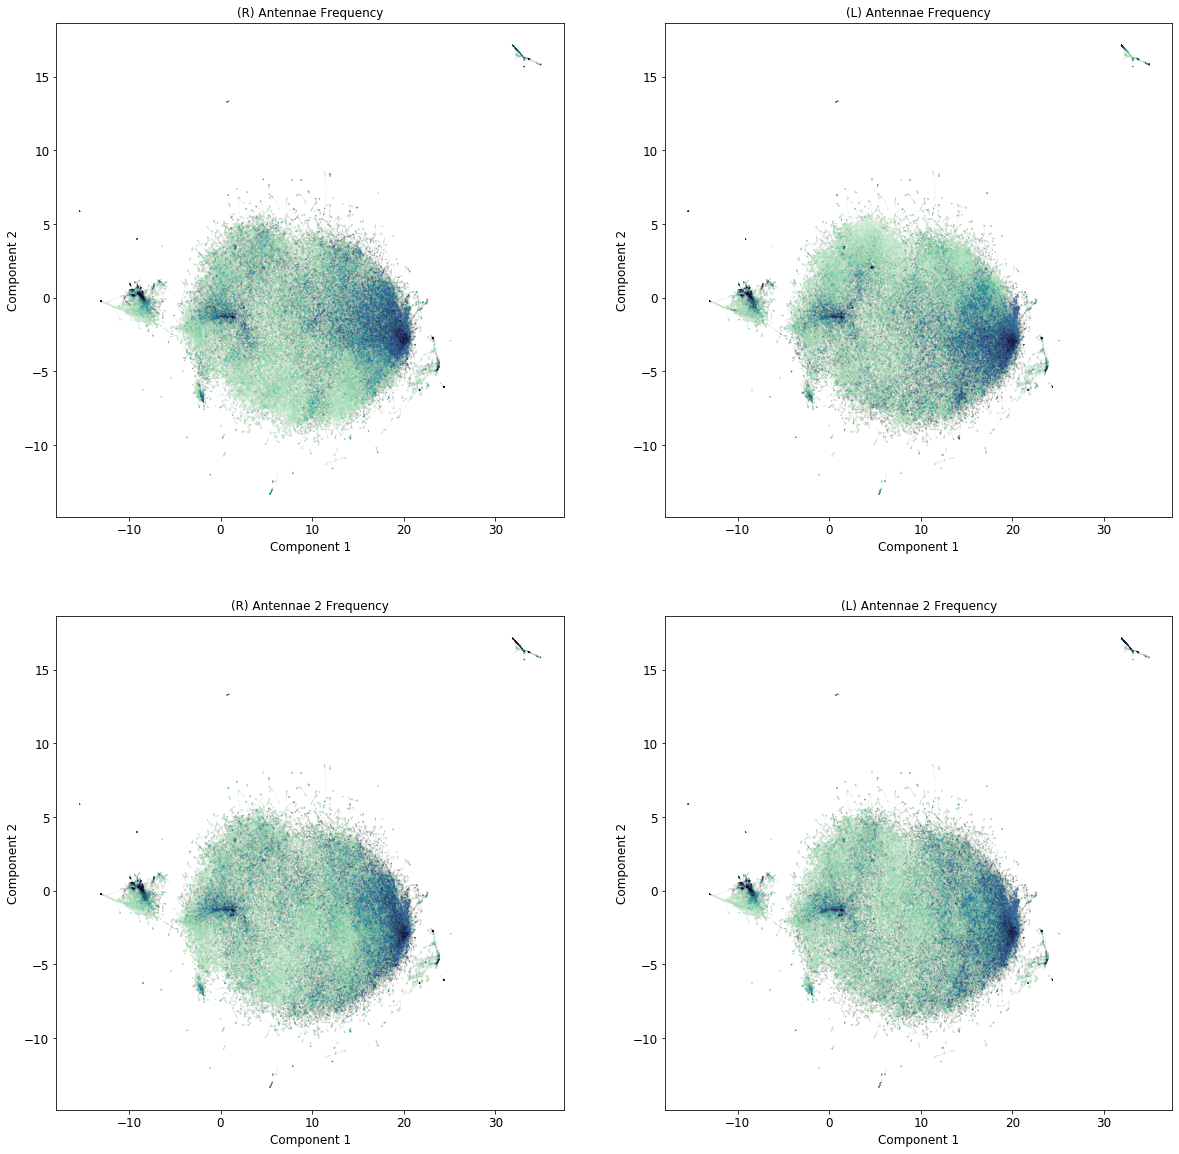

In [15]:
# Figure Information
max_freq_idx = np.argmax(tot_power[:,:-1,:], axis=1)
max_freq = freq[max_freq_idx]
num_freq = len(freq)

# Freq Color Scheme
freq_color_palette = sns.color_palette('mako_r', num_freq)
cmap1, norm1 = colors.from_levels_and_colors(freq, freq_color_palette, extend="max")

# Figures
fig, ax = plt.subplots(2,2, figsize=(20,20))
for angle_idx in tqdm(range(4)):
    fig_title = f"{config['angle_labels'][angle_idx]} Frequency"
    freq_cluster_colors = np.array([freq_color_palette[f] for f in max_freq_idx[angle_idx]])

    ax[angle_idx%2, angle_idx//2].scatter(tot_embed[:,0], tot_embed[:,1], color=freq_cluster_colors, alpha=0.005, s=1)  
    ax[angle_idx%2, angle_idx//2].set(xlabel='Component 1', ylabel='Component 2', title=fig_title)
plt.show()

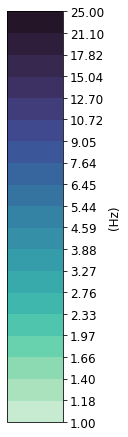

In [28]:
# Colorbar
fig, ax = plt.subplots(figsize=(1,15))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap1, norm=norm1, ticks=freq, orientation='vertical')
cb1.set_label('(Hz)')
plt.show()

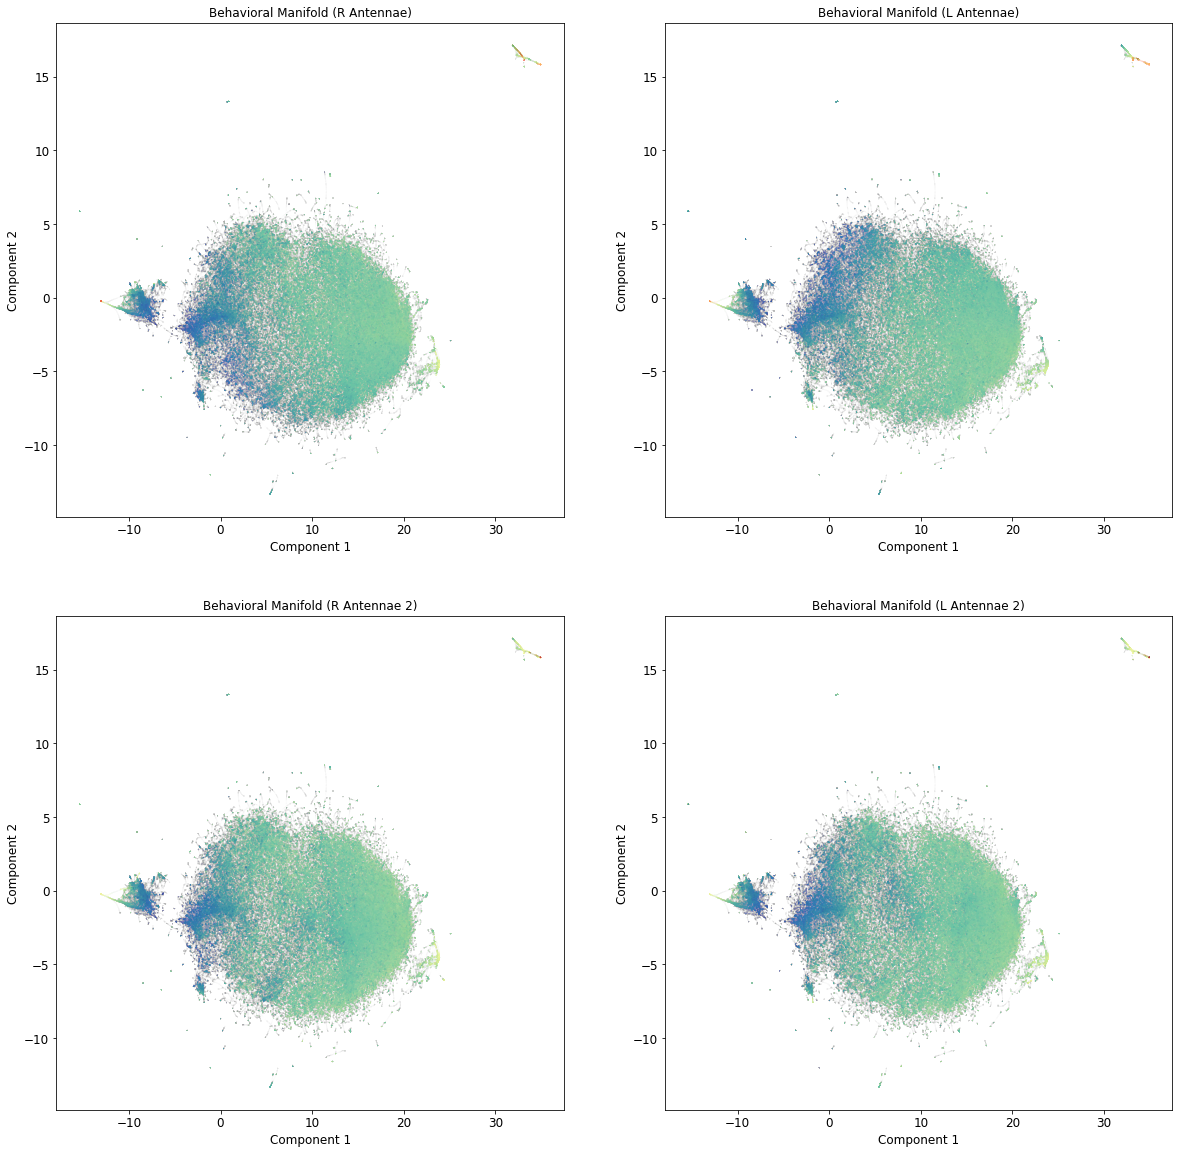

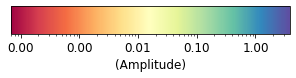

In [78]:
max_amp_idx = np.max(tot_power[:,:-1,:], axis=1)
# RdYlBu
cmap = "Spectral"
# Amplitude Color Scheme
body_min = np.min(max_amp_idx)
body_max = np.max(max_amp_idx)
norm = matplotlib.colors.LogNorm(vmin=body_min, vmax=body_max)

# Figures
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].scatter(tot_embed[:,0], tot_embed[:,1],  c=max_amp_idx[0], cmap=cmap, norm=norm, alpha=0.005, s=1)  
ax[0,0].set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (R Antennae)")

ax[1,0].scatter(tot_embed[:,0], tot_embed[:,1],  c=max_amp_idx[1], cmap=cmap, norm=norm, alpha=0.005, s=1)  
ax[1,0].set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (R Antennae 2)")

ax[0,1].scatter(tot_embed[:,0], tot_embed[:,1], c=max_amp_idx[2], cmap=cmap, norm=norm, alpha=0.005, s=1)  
ax[0,1].set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (L Antennae)")

ax[1,1].scatter(tot_embed[:,0], tot_embed[:,1],  c=max_amp_idx[3], cmap=cmap, norm=norm, alpha=0.005, s=1)  
ax[1,1].set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold (L Antennae 2)")
plt.show()

# Colorbar
fig, ax = plt.subplots(figsize=(5, 1))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap(cmap), norm=norm, orientation='horizontal')
cb1.set_label('(Amplitude)')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()

<h1><font color="blue">Cluster (HDBSCAN)</font></h1>

In [6]:
import hdbscan
from sklearn.utils import shuffle

freq = np.array([ 1.        ,  1.18461108,  1.40330341,  1.66236876,  1.96926045,
        2.33280775,  2.76346991,  3.27363707,  3.87798674,  4.59390605,
        5.441992  ,  6.44664402,  7.63676592,  9.04659752, 10.71669965,
       12.69512113, 15.03878113, 17.81510674, 21.10397281, 25.        ])

In [40]:
# # hdbscan clustering
# clusterer = hdbscan.HDBSCAN(min_cluster_size=9000, 
#                             min_samples=20, memory="memory", 
#                             cluster_selection_method="leaf").fit(tot_embed[:,:-1])
# # parameters
# num_clusters = np.max(clusterer.labels_)+1
# outlier_pts = (clusterer.labels_ == -1)
# labeled_pts = (clusterer.labels_ != -1)

# print(f"Frac Outlier: {len(np.where(outlier_pts)[0])/len(clusterer.labels_)}")
# print(f"# Clusters: {num_clusters}")

# # cmap: coloring
# color_palette = sns.color_palette('rainbow', num_clusters)
# color_palette = shuffle(color_palette)
# cluster_colors = [color_palette[x] if x >= 0
#                   else (0.5, 0.5, 0.5)
#                   for x in clusterer.labels_]
# cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, clusterer.probabilities_)])

Frac Outlier: 0.6083283658720179
# Clusters: 26


In [27]:
# hdbscan clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=7000, 
                            min_samples=10,
                            cluster_selection_epsilon=0,
                            cluster_selection_method="leaf",
                            memory="memory"
                           ).fit(tot_embed[:,:-1])
# parameters
num_clusters = np.max(clusterer.labels_)+1
outlier_pts = (clusterer.labels_ == -1)
labeled_pts = (clusterer.labels_ != -1)

print(f"Frac Outlier: {len(np.where(outlier_pts)[0])/len(clusterer.labels_)}")
print(f"# Clusters: {num_clusters}")

# cmap: coloring
color_palette = sns.color_palette('rainbow', num_clusters)
color_palette = shuffle(color_palette)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)])

Frac Outlier: 0.6624716218598221
# Clusters: 29


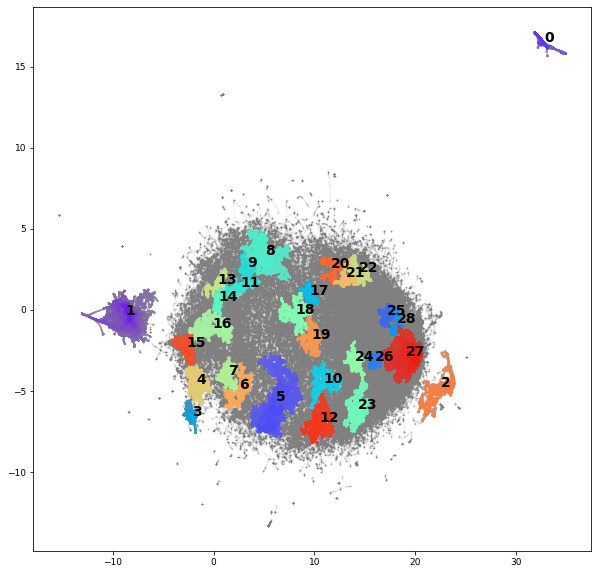

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

# cluster colors
ax.scatter(tot_embed[outlier_pts,0], tot_embed[outlier_pts,1], 
           c="gray", s=1, alpha=0.01)
ax.scatter(tot_embed[labeled_pts,0], tot_embed[labeled_pts,1], 
           c=cluster_member_colors[labeled_pts], s=1, alpha=0.2)

# numbering
cluster_mean = []
for i in tqdm(range(num_clusters)):
    idx = (clusterer.labels_==i)
    ax.annotate(i, np.mean(tot_embed[idx,:-1], axis=0), fontsize=14, fontweight='bold')
    cluster_mean.append(np.mean(tot_embed[idx,:-1], axis=0).tolist())
cluster_mean = np.array(cluster_mean)

plt.show()

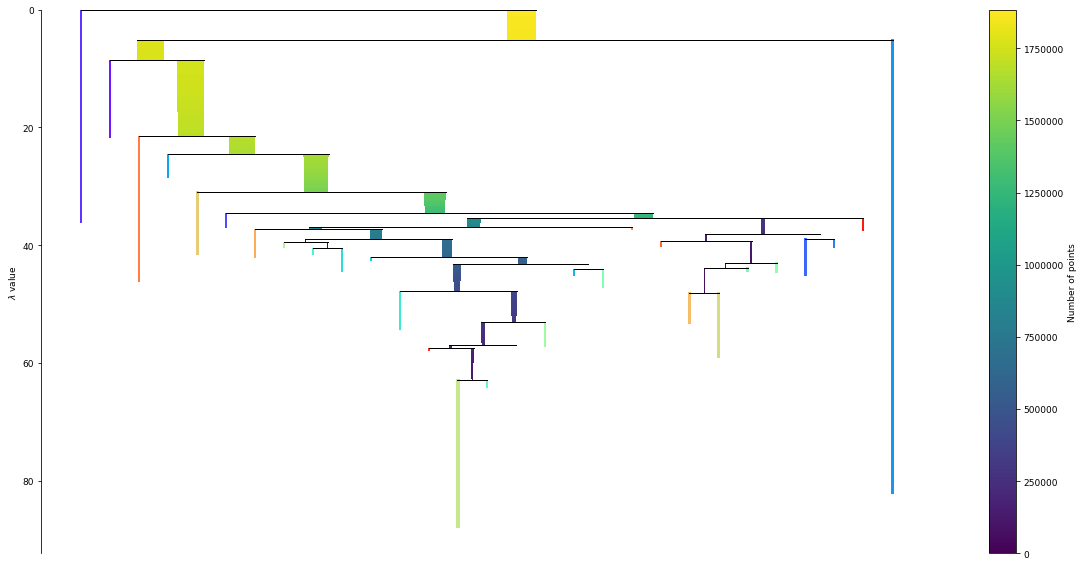

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=color_palette,
                              axis=ax)

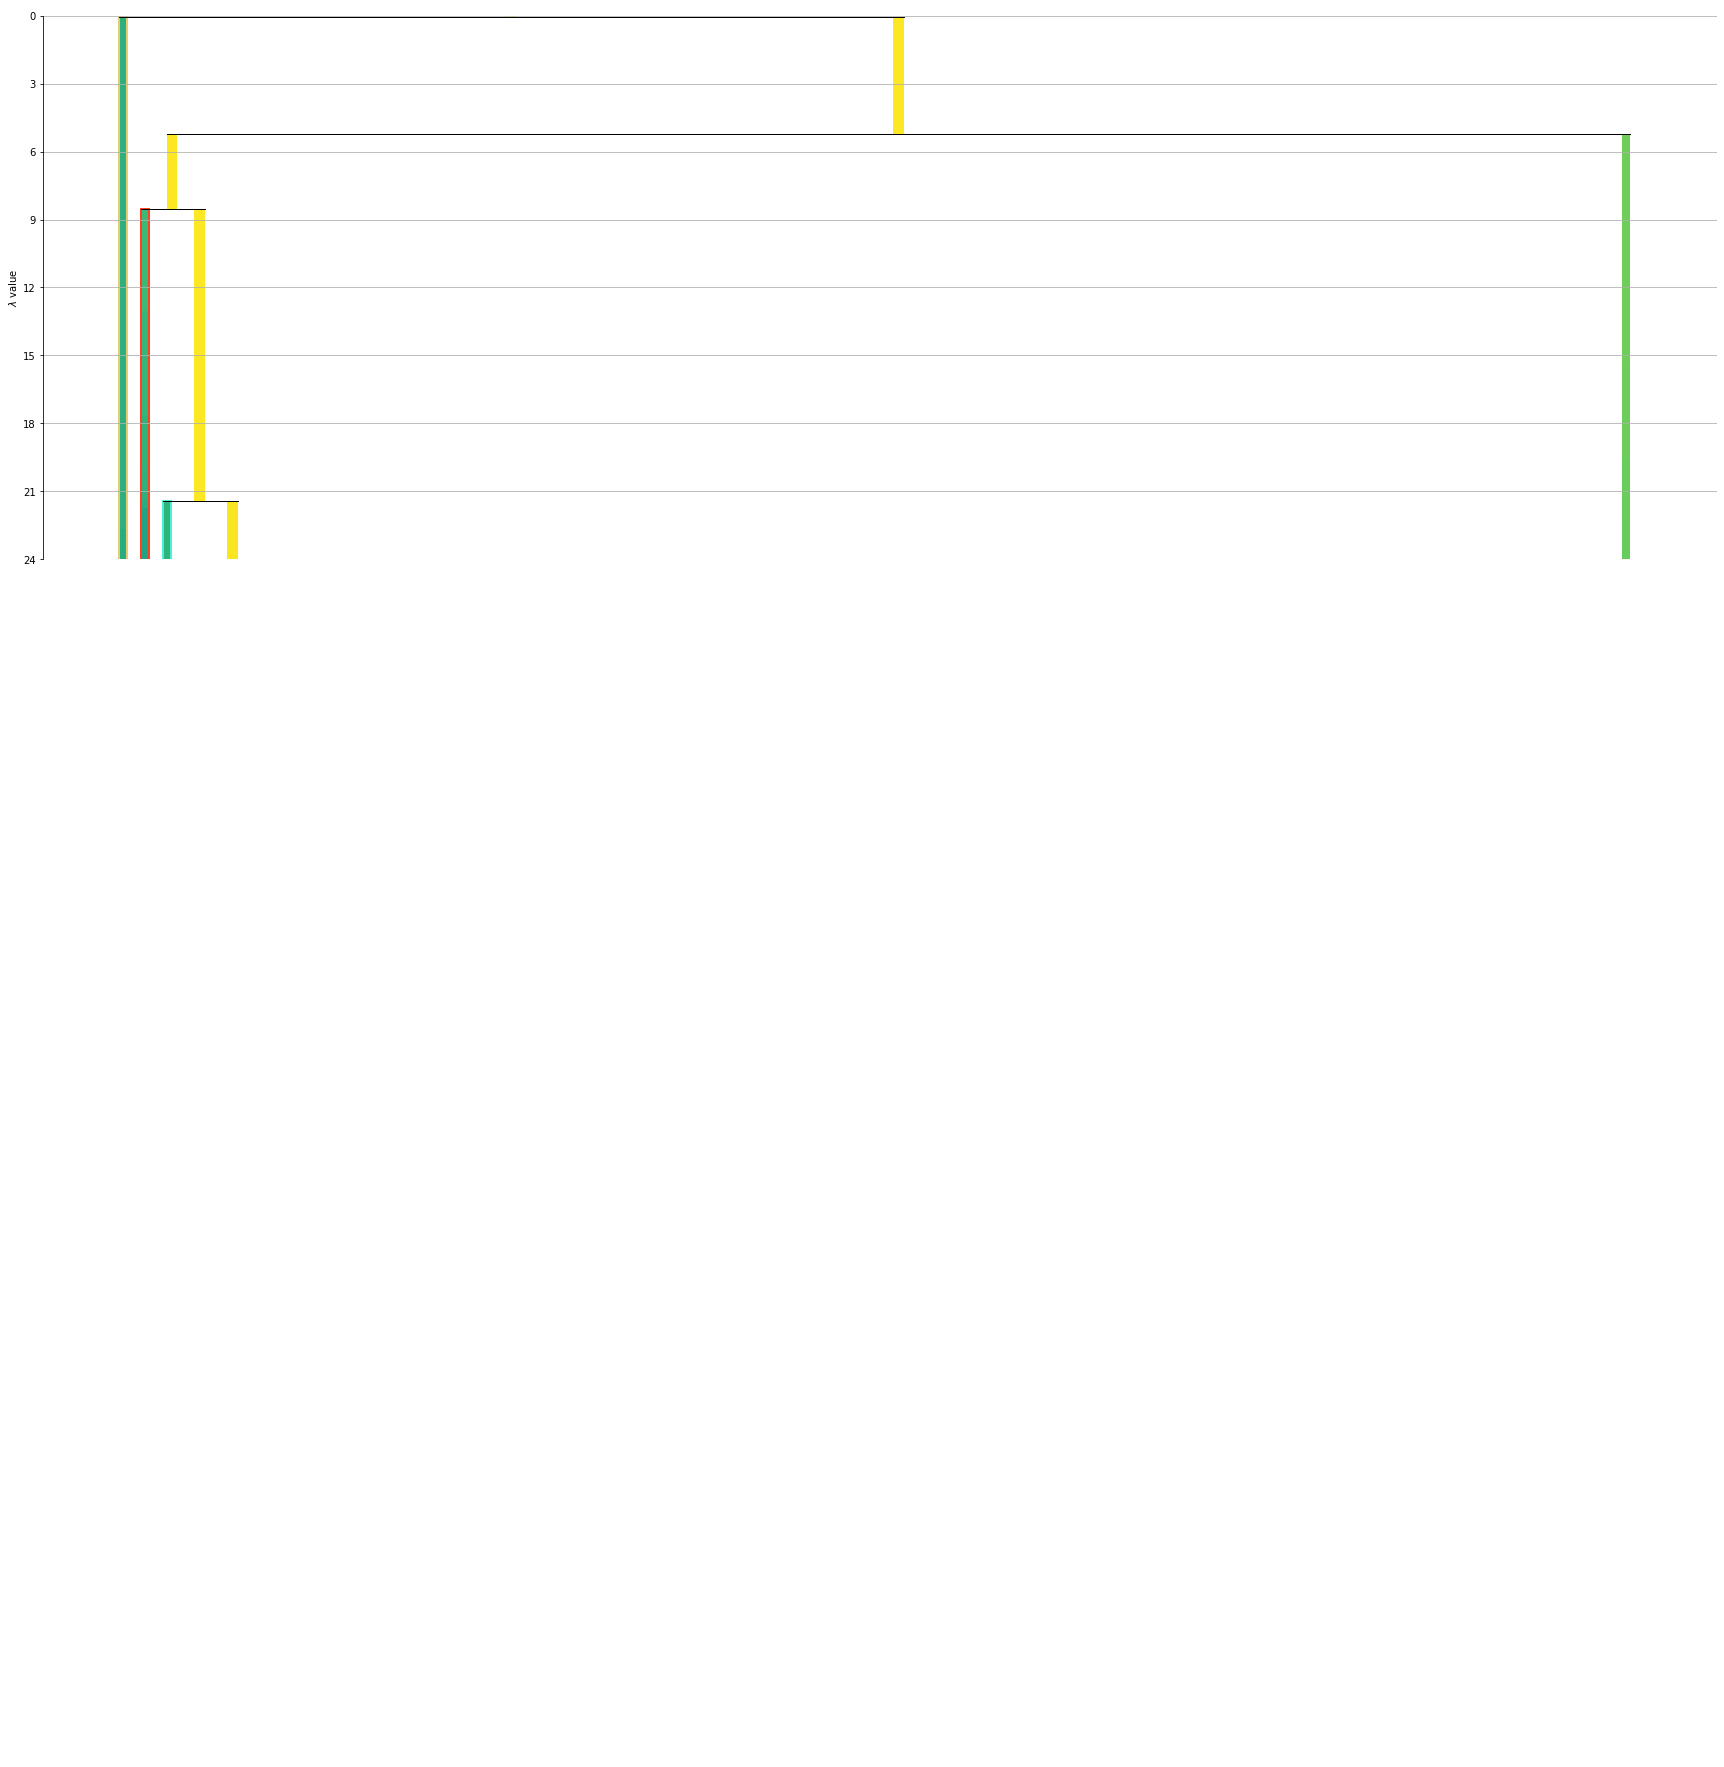

In [18]:
fig, ax = plt.subplots(figsize=(30,10))
ax.set(ylim=(0,24), yticks=np.arange(0,25,3))
clusterer.condensed_tree_.plot(leaf_separation=2,
                               label_clusters=True,
                               log_size=True,
                               colorbar=False,
                               select_clusters=True,
                               selection_palette=color_palette,
                              axis=ax)
ax.grid(axis='y')

<h1><font color="blue">Save Cluster</font></h1>

In [41]:
# Save Cluster
num_fr = len(clusterer.labels_)
cluster_data = np.zeros((num_fr, 2))
cluster_data[:,0] = clusterer.labels_
cluster_data[:,1] = clusterer.probabilities_

INFO_LIST = list(INFO.values())
INFO_LIST.sort(key=lambda x: x['order'])

# Save Cluster Data
fr_start = 0
for file in INFO_LIST:
    if config['save_clusters']:
        np.save(f"{file['directory']}/clusters.npy", cluster_data[fr_start:fr_start+file["number_frames"],:])
    fr_start += file["number_frames"]

<h1><font color="blue">Power Spectrogram</font></h1>

In [25]:
matplotlib.rc('font', size=9)
matplotlib.rc('axes', titlesize=9)

freq = np.array([ 1.        ,  1.18461108,  1.40330341,  1.66236876,  1.96926045,
        2.33280775,  2.76346991,  3.27363707,  3.87798674,  4.59390605,
        5.441992  ,  6.44664402,  7.63676592,  9.04659752, 10.71669965,
       12.69512113, 15.03878113, 17.81510674, 21.10397281, 25.        ])


angle_labels = ['(R) Antennae',
 '(R) Antennae 2',
 '(L) Antennae',
 '(L) Antennae 2']

In [30]:
num_clusters = np.max(clusterer.labels_) + 1

fig, ax = plt.subplots(8,5,figsize=(38,35), dpi=400)
for i_cluster in range(num_clusters):
    idx_cluster = (clusterer.labels_ == i_cluster) & (clusterer.probabilities_>0.7)
    num_fr_in_cluster = len(np.where(idx_cluster)[0])
    
    xtick_idx = np.arange(1, len(freq), 3)
    
    # Create figure
    
    ax[i_cluster//5, i_cluster%5].imshow(np.mean(tot_power[:,:-1,idx_cluster], axis=2), norm = matplotlib.colors.LogNorm(), 
              vmin=0.01, vmax=np.max(tot_power[:,:-1,:]), cmap='hot')
    
    # Figure Setting Specific
    if i_cluster%5 == 0: 
        ax[i_cluster//5, i_cluster%5].set(xticks=xtick_idx, xticklabels=np.around(freq[xtick_idx], 1), 
               yticks=np.arange(len(angle_labels)), yticklabels=angle_labels,
               aspect=1.1, xlabel="Frequency", 
               title=f"Avg Power Cluster {i_cluster} ({num_fr_in_cluster} frames)")
    else:
        ax[i_cluster//5, i_cluster%5].set(xticks=xtick_idx, xticklabels=np.around(freq[xtick_idx], 1), yticks=[],
               aspect=1.1, xlabel="Frequency", 
               title=f"Avg Power Cluster {i_cluster} ({num_fr_in_cluster} frames)")
plt.savefig("videos/round2_resnet101_multivideo/ClusterPowerSpectrogram")
plt.show()

<h1><font color="blue">Video</font></h1>

In [53]:
from video import Video

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

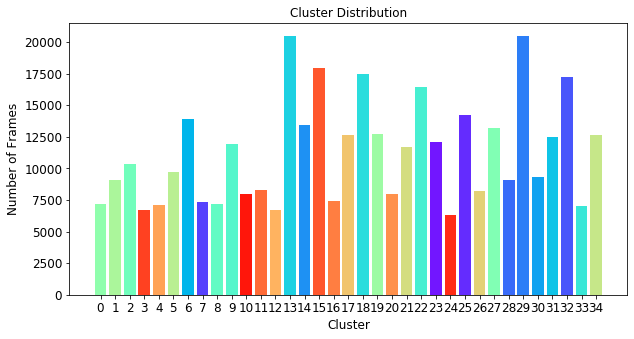

In [54]:
num_clusters = np.max(clusterer.labels_) + 1
cluster_distribution = []
for clust_i in range(num_clusters):
    clust_idx = np.where(clusterer.labels_ == clust_i)[0]
    cluster_distribution.append(len(clust_idx))

# Distribution figure  
fig, ax = plt.subplots(figsize=(10,5)) 
xticks = [str(i) for i in range(num_clusters)]
ax.bar(xticks, cluster_distribution, color=color_palette)
ax.set(xlabel="Cluster", ylabel="Number of Frames", title="Cluster Distribution")
plt.show()

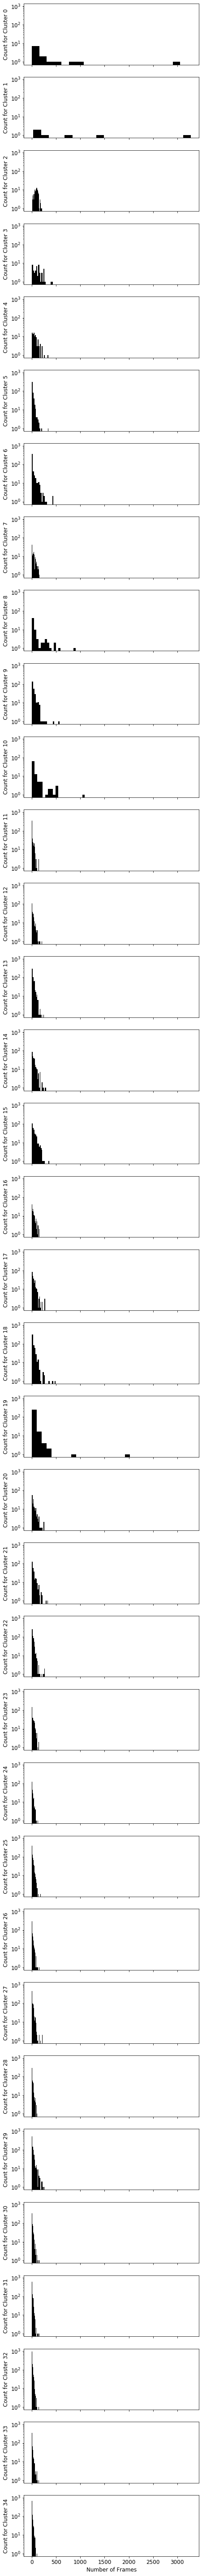

In [55]:
fig, ax = plt.subplots(num_clusters, 1, figsize=(7,3*num_clusters), sharex=True, sharey=True)
video_cluster_idx = {}
for clust_i in range(num_clusters):
    clust_idx = np.where(clusterer.labels_ ==clust_i)[0]
    difference = np.diff(clust_idx)
    
    # Find consecutive break
    break_idx = np.where(difference != 1)[0]
    mod_break_idx = np.insert(break_idx, 0, 0)
    break_difference = np.diff(mod_break_idx)
    
    # Find max consecutive
    sorted_idx = np.argsort(break_difference)
    top_idx = sorted_idx[-config['num_sample_videos']:]
    video_idx = [[ clust_idx[mod_break_idx[idx]+1], clust_idx[mod_break_idx[idx+1]+1]] for idx in top_idx]
    video_cluster_idx[clust_i] = video_idx
    
    # Cluster Duration Distribution
    ax[clust_i].hist(break_difference, bins=20, color='k')
    ax[clust_i].set(ylabel=f"Count for Cluster {clust_i}", yscale="log")
    if clust_i == num_clusters-1:
        ax[clust_i].set(xlabel="Number of Frames")
        
plt.show()

In [149]:
result_path = "results/round2_legs_antennae"

# Load Config Files
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])  
config_path = "."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Format Data
tot_bp, tot_bp_scaled, tot_angles, tot_rotations, tot_power, tot_embed, tot_clusters = [], [], [], [], [], [], []
for file in tqdm(INFO_values):
    tot_bp.append( np.load(f"{file['directory']}/bodypoints.npy") )
    tot_bp_scaled.append( np.load(f"{file['directory']}/scaled_bodypoints.npy") )
    tot_angles.append( np.load(f"{file['directory']}/angles.npy") )
    tot_power.append( np.load(f"{file['directory']}/power.npy") )
    tot_embed.append( np.load(f"{file['directory']}/embeddings.npy") )
    tot_clusters.append( np.load(f"{file['directory']}/clusters.npy") )
tot_bp = np.concatenate(tot_bp)
tot_bp_scaled = np.concatenate(tot_bp_scaled)
tot_angles = np.concatenate(tot_angles)
tot_power = np.concatenate(tot_power, axis=2)
tot_embed = np.concatenate(tot_embed)
tot_clusters = np.concatenate(tot_clusters)

# Create Video Class
video_creator = Video(
    config=config,
    INFO=INFO,
    bodypoints=tot_bp, 
    angles=tot_angles, 
    power=tot_power,
    embed=tot_embed, 
    cluster=tot_clusters[:,0]
)

# Setup Video
video_creator.setup()

# Create Videos
for clust_i, list_idx in tqdm(video_cluster_idx.items(), desc="Cluster Loop"):
    for (start_fr, stop_fr) in tqdm(list_idx, desc="Video Loop"):
        # Set Frame Range
        fr_length = stop_fr-start_fr 
        if fr_length > config["max_video_length"]:
            start, stop = start_fr, start_fr+config["max_video_length"]
        else:
            pad = int(fr_length/2)
            start, stop = start_fr-pad, stop_fr+pad
        
        # Define Filename
        filepath = f"{save_video_path}/cluster{clust_i}_frame{start}-{stop}.mp4"
        
        # Create Video
        video_creator.create_video_legs(start, stop, filepath)

results/round2_legs_antennae/02XXmidfr_antmovie200929192351


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '10500x7000', '-pix_fmt', 'rgba', '-r', '25', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', './videos/round2_legs_antennae/cluster0_frame304096-304176.mp4']' returned non-zero exit status 255.

<h1><font color="blue">Combined Video</font></h1>

In [3]:
import skvideo.io
import matplotlib.animation as animation
from tqdm.notebook import tqdm

In [4]:
result_path = "results/round2_legs_antennae_resnet101"

# Load Config Files
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])  
config_path = "."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Format Data
tot_bp, tot_bp_scaled, tot_angles, tot_rotations, tot_power, tot_embed, tot_clusters = [], [], [], [], [], [], []
for file in tqdm(INFO_values):
    tot_bp.append( np.load(f"{file['directory']}/bodypoints.npy") )
    tot_bp_scaled.append( np.load(f"{file['directory']}/scaled_bodypoints.npy") )
    tot_angles.append( np.load(f"{file['directory']}/angles.npy") )
    tot_power.append( np.load(f"{file['directory']}/power.npy") )
    tot_embed.append( np.load(f"{file['directory']}/embeddings.npy") )
    tot_clusters.append( np.load(f"{file['directory']}/clusters.npy") )
tot_bp = np.concatenate(tot_bp)
tot_bp_scaled = np.concatenate(tot_bp_scaled)
tot_angles = np.concatenate(tot_angles)
tot_power = np.concatenate(tot_power, axis=2)
tot_embed = np.concatenate(tot_embed)
tot_clusters = np.concatenate(tot_clusters)

In [6]:
num_videos_per_clusters = 16

# Determine Which frames to Abstract
num_clusters = int(np.max(tot_clusters[:,0]).item()) + 1
cluster_distribution = []
for clust_i in range(num_clusters):
    clust_idx = np.where(tot_clusters[:,0] == clust_i)[0]
    cluster_distribution.append(len(clust_idx))

video_cluster_idx = {}
for clust_i in range(num_clusters):
    clust_idx = np.where(tot_clusters[:,0] ==clust_i)[0]
    difference = np.diff(clust_idx)

    # Find consecutive break
    break_idx = np.where(difference != 1)[0]
    mod_break_idx = np.insert(break_idx, 0, 0)
    break_difference = np.diff(mod_break_idx)

    # Find max consecutive
    sorted_idx = np.argsort(break_difference)
    top_idx = sorted_idx[-num_videos_per_clusters:]
    video_idx = np.array([[ clust_idx[mod_break_idx[idx]+1], clust_idx[mod_break_idx[idx+1]+1]] for idx in top_idx])
    video_cluster_idx[clust_i] = video_idx

In [34]:
# find video filename
INFO_values = list(INFO.values())
INFO_values.sort(key=lambda x: x['order'])

global_start_frames = np.array([val['global_start_fr'] for val in INFO_values])
global_stop_frames = np.array([val['global_stop_fr'] for val in INFO_values])
global_directories = np.array([val['directory'] for val in INFO_values])

In [24]:
# animal video data
video_i, file_start_fr = {}, {}
for i, (start, stop) in enumerate(tqdm(video_cluster_idx[2], desc="Collecting Videos")):
    file_bool = start >= global_start_frames
    if any(file_bool):
        file_start_fr[i] = global_start_frames[file_bool][-1]
        file_path = global_directories[file_bool][-1]
        print(file_path)
        file_key = file_path.split("/")[-1]

results/round2_legs_antennae/05YGminfd_antmovie200928203953
results/round2_legs_antennae/02WGmidfd_antmovie201010194713
results/round2_legs_antennae/06TTminfr_antmovie200927204039
results/round2_legs_antennae/04Tdminfd_antmovie200927203026
results/round2_legs_antennae/05BOmajfr_antmovie200929204645
results/round2_legs_antennae/06WRmajfr_antmovie200929210434
results/round2_legs_antennae/04Ddminfr_antmovie200926204443
results/round2_legs_antennae/05BOmajfr_antmovie200929204645
results/round2_legs_antennae/04Ddminfd_antmovie200926205755
results/round2_legs_antennae/05WOmajfr_antmovie201010204948
results/round2_legs_antennae/05YGminfd_antmovie200928203953
results/round2_legs_antennae/05YGminfr_antmovie200928203217
results/round2_legs_antennae/04BTmajfr_antmovie200929203218
results/round2_legs_antennae/04YWmajfr_antmovie200928201629
results/round2_legs_antennae/03WPmajfr_antmovie201010200214
results/round2_legs_antennae/06GRmidfd_antmovie201010211657



In [75]:
fig, ax = plt.subplots(4,4,figsize=(10,10))
ang_palette = sns.color_palette('tab10', 10)

# video format        
FFMpegWriter = animation.writers['ffmpeg']
writer = FFMpegWriter(fps=10)
save_path="videos/test.mp4"
with writer.saving(fig, save_path, dpi=300):
    for fr_i in tqdm(np.arange(0, 100), desc="Frame Loop"):
        for i, (start, stop) in tqdm(video_cluster_idx[2]):
            ax[i//4,i%4].clear()
            ax[i//4,i%4].set_axis_off()
            ax[i//4,i%4].set(xlim=(-3,3), ylim=(-3,3))

            bp_linewidth = 2
            bp_markersize = 3
            alpha = 0.8
            fr, shadow_i = start+fr_i, 0

            # left side
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,0:4,0], tot_bp_scaled[fr+shadow_i,0:4,1], 
                     c='k', alpha=alpha, 
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,5:8,0], tot_bp_scaled[fr+shadow_i,5:8,1], 
                     c=ang_palette[0], alpha=alpha, 
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,8:11,0], tot_bp_scaled[fr+shadow_i,8:11,1], 
                     c=ang_palette[1], alpha=alpha, 
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,11:14,0], tot_bp_scaled[fr+shadow_i,11:14,1], 
                     c=ang_palette[2], alpha=alpha, 
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,14:17,0], tot_bp_scaled[fr+shadow_i,14:17,1], 
                     c=ang_palette[3], alpha=alpha, 
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            # right side
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,18:21,0], tot_bp_scaled[fr+shadow_i,18:21,1], 
                     c=ang_palette[4], alpha=alpha,
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,21:24,0], tot_bp_scaled[fr+shadow_i,21:24,1], 
                     c=ang_palette[5], alpha=alpha,
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,24:27,0], tot_bp_scaled[fr+shadow_i,24:27,1], 
                     c=ang_palette[6], alpha=alpha,
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)
            ax[i//4,i%4].plot(tot_bp_scaled[fr+shadow_i,27:30,0], tot_bp_scaled[fr+shadow_i,27:30,1], 
                     c=ang_palette[7], alpha=alpha,
                     marker="o", linewidth=bp_linewidth, markersize=bp_markersize)

        writer.grab_frame()
    plt.close()
        
    

In [31]:
# find video filename
INFO_values = list(INFO.values())
INFO_values.sort(key=lambda x: x['order'])

global_start_frames = np.array([val['global_start_fr'] for val in INFO_values])
global_stop_frames = np.array([val['global_stop_fr'] for val in INFO_values])
global_directories = np.array([val['directory'] for val in INFO_values])

In [39]:
for (start, stop) in video_cluster_idx[2]:
    # animal video data
    file_bool = [a and b for a, b in zip(start >= global_start_frames, stop < global_stop_frames)]
    if any(file_bool):
        file_start_fr = global_start_frames[file_bool].item()
        file_path = global_directories[file_bool].item()
        print(file_path)
        file_key = file_path.split("/")[-1]
        video_path = glob(f"{file_path}/*.avi")[0]

results/round2_legs_antennae/05YGminfd_antmovie200928203953


IndexError: list index out of range

In [ ]:
video = skvideo.io.vread(video_path)

<h1><font color="blue">Caste and Environmental Conditions</font></h1>

In [31]:
%matplotlib inline
# %matplotlib qt

matplotlib.rc('font', size=MEDIUM_SIZE)
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)

In [32]:
caste_data = {"min": [], "mid": [], "maj":[]}
# env_data = {"trail": [], "food": [], "free":[], "groom":[]}
env_data = {"food": [], "free":[]}

for item in INFO_values:
    path = item['directory']
    start, stop = item['global_start_fr'], item['global_stop_fr']

    # Caste Condition
    if path.find("min") is not -1:
        caste_data["min"].extend(tot_embed[start:stop].tolist())
    if path.find("mid") is not -1:
        caste_data["mid"].extend(tot_embed[start:stop].tolist())
    if path.find("maj") is not -1:
        caste_data["maj"].extend(tot_embed[start:stop].tolist())
    
    # Environmental Conditions
#     if path.find("trail") is not -1:
#         env_data["trail"].extend(tot_embed[start:stop].tolist())
    if path.find("fd") is not -1:
        env_data["food"].extend(tot_embed[start:stop].tolist())
    if path.find("fr") is not -1:
        env_data["free"].extend(tot_embed[start:stop].tolist())
#     if path.find("groom") is not -1:
#         env_data["groom"].extend(tot_embed[start:stop].tolist())

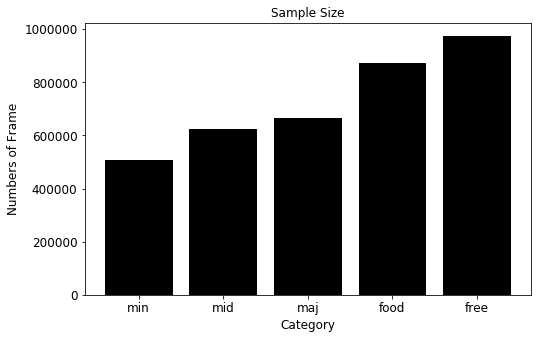

In [33]:
data_type = []
type_num_fr = []

fig, ax = plt.subplots(figsize=(8, 5))
for key, val in caste_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
for key, val in env_data.items():
    data_type.append(key)
    type_num_fr.append(len(val))
    
ax.bar(data_type, type_num_fr, color='k')
ax.set(xlabel='Category', ylabel='Numbers of Frame', title="Sample Size")
plt.show()

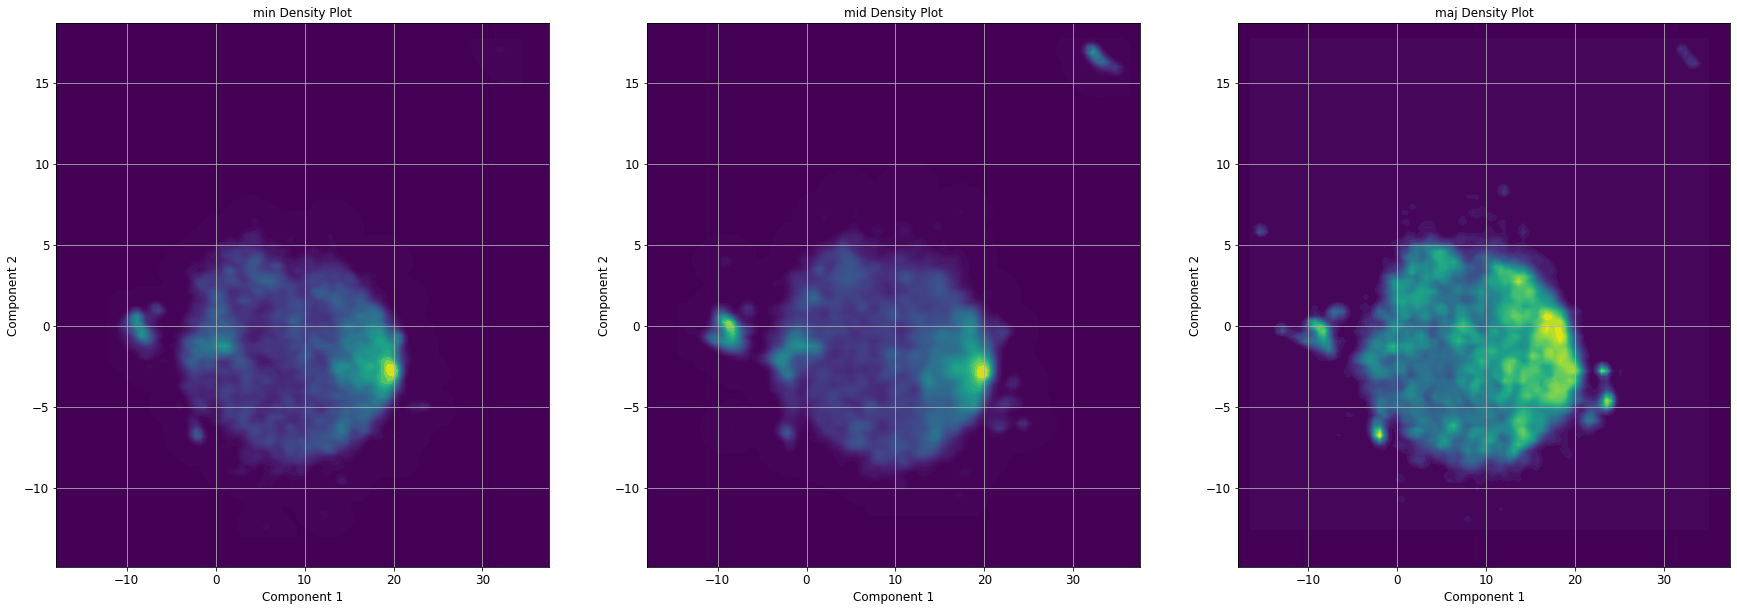

In [36]:
# caste
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for idx, (key, cat_embed) in enumerate(caste_data.items()):
    cat_embed = np.array(cat_embed)
    # density
    sns.kdeplot(x=cat_embed[:,0], y=cat_embed[:,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

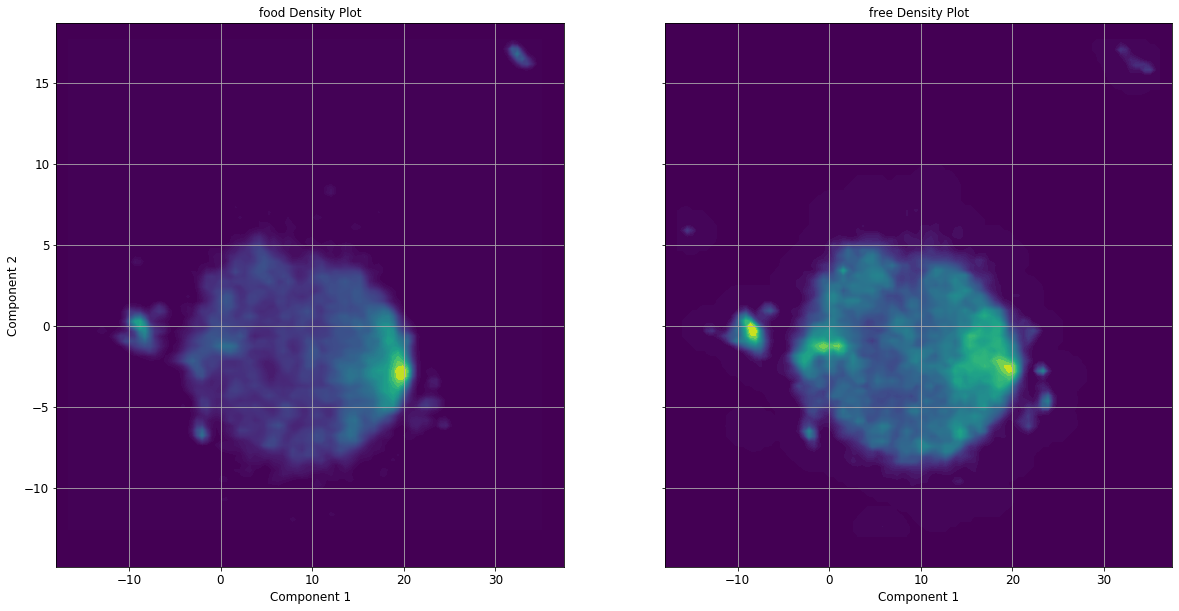

In [37]:
# Environment

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
for idx, (key, cat_embed) in enumerate(env_data.items()):
    cat_embed = np.array(cat_embed)
    # density
    sns.kdeplot(x=cat_embed[:,0], y=cat_embed[:,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax[idx])
    
    ax[idx].set(xlabel='Component 1', ylabel='Component 2', 
                title=f"{key} Density Plot", facecolor='#440054',
               xlim=ax_base.get_xlim(), ylim=ax_base.get_ylim()) # , facecolor='#000096'
    ax[idx].grid(which="major")
plt.show()

<h1><font color="blue">Proportion Matrix</font></h1>

In [58]:
%matplotlib qt
import textwrap

matplotlib.rc('font', size=6)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [59]:
num_cluster = np.max(gmm_label)+1
num_files = len(files_ref)

proportion_matrix = np.zeros((len(files_ref), num_cluster))
row_name = []

for files_idx, (path, fr_range) in enumerate(files_ref.items()):
    # Parse Files
    base = os.path.basename(path)
    basename = base.split("DeepCut")[0]
    row_name.append(basename)
    cluster = gmm_label[fr_range[0]:fr_range[1]]
    # Create Proportion Matrix
    for clust_i in range(num_cluster):
        proportion_matrix[files_idx, clust_i] = len(np.where(cluster == clust_i)[0])/len(cluster)

# Proportion Figure
fig, ax = plt.subplots(figsize=(20,5)) 
ax.imshow(proportion_matrix.T, cmap="jet")

row_name_mod = [row.replace("_", "\n").replace("-", "\n").replace("2018", "18") for row in row_name]

plt.xticks(np.arange(num_files), row_name_mod, rotation=0)
ax.set(ylabel='Clusters', xlabel='Files', 
                title=f"Proportion Matrix")
plt.tight_layout(pad=0)
plt.show()